# PROGETTO DWM 2021
### Giovanni Costa - 880892

Indice:
- [Analisi del dataset "Train"](#analisi_train)
- [Analisi del dataset "Properties"](#analisi_prop)
- [Features Engineer](#features_engineer)
    - [Analisi delle features numeriche e categoriali](#features_num_cat)
    - [Gestione dei missing values e rimozione delle colonne non necessarie o che presentano multicollinearità](#missing_val)
        - [Recupero dei valori missing di features basate sulla posizione e sulle tasse](#recover_missing_pos_tax)
    - [Aggiunta di features custom potenzialmente utili](#custom_features) 
- [Features importance, features selection e preparazione del dataset finale](#features_selection)
- [Corstruzione del modello sfruttante Random Forest e tuning dei suoi parametri](#mod_1)
- [Corstruzione del modello sfruttante Gradient Boosting e tuning dei suoi parametri](#mod_2)
- [Comparazione e analisi dei modelli](#comparison_and_analisys)
- [Considerazioni finali](#final)

In [1]:
'''
    - Analisi delle variabili numeriche (duplicati e missing val, correlaz, ..) https://www.kaggle.com/code/lauracozma/eda-data-cleaning-feature-engineering (dividere per geo e per tax le features)
    e analisi della variabili categoriali (anche quelle con gli id)
    - Filling dei missing value e rimozione di alcune colonne (KNN o Random forest)
    - Aggiunta di features custom utili

ONEHOTENCODED delle var categoriali int?
- Features importance, features selection e preparazione del dataset
    - (anche analisi delle correlazioni, outliers, rescaling val (le location vanno divise per 10^6), label encoding)
- Corstruzione modello 1 e tuning dei parametri
- Corstruzione modello 2 e tuning dei parametri
- Comparazione e analisi dei modelli
- Considerazioni finali

https://www.kaggle.com/code/nikunjm88/creating-additional-features SI

https://www.kaggle.com/code/nikunjm88/carefully-dealing-with-missing-values SI

https://www.kaggle.com/code/auroralht/restoring-the-missing-geo-data/notebook SI

https://www.kaggle.com/code/nikitabu/zillow-eda-opportunities-for-feature-engineering

https://www.kaggle.com/code/hyewon328/zillow-analysis-with-eda NO

Metti dei grafici utili sulle analisi magari
https://www.kaggle.com/code/dasarimohana/zillow-house-price-prediction-by-dasari-mohana (Progetto completo fatto da uno)
''';

In [2]:
#Import delle librerie
%matplotlib inline
import sys
sys.path.insert(0, '')
import utils_copy as fun #my functions.py file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV 


input_folder='../data/'
data_file_name='properties_2016.csv'
train_file_name='train_2016_v2.csv'
#feature_dict_file_name='zillow_data_dictionary.xlsx'

<a id='analisi_train'></a>
### Analisi del dataset "Train"

In [3]:
#Lettura del dataset
df_train=pd.read_csv(input_folder+train_file_name)
df_train.info()
print('Shape: ', df_train.shape)

#Conversione della colonna 'transactiondate' in tipo np.datetime64
df_train['transactiondate']=pd.to_datetime(df_train['transactiondate'], format='%Y-%m-%d')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90275 entries, 0 to 90274
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   parcelid         90275 non-null  int64  
 1   logerror         90275 non-null  float64
 2   transactiondate  90275 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 2.1+ MB
Shape:  (90275, 3)


In [4]:
#Missing values ratio
df_train.isna().sum()/df_train.shape[0] *100

parcelid           0.0
logerror           0.0
transactiondate    0.0
dtype: float64

In [5]:
#Analisi dei duplicati
print(df_train.duplicated(subset='parcelid').sum())
print(df_train.duplicated(subset=['parcelid', 'transactiondate']).sum())

125
0


Notiamo che il dataset contiene 3 colonne:
- Parcelid: id univoco che identifica ad ogni istanza di casa
- Logerror: misura che dovremmo utilizzare per verificare la bontà del nostro modello <br>
*Zillow is asking you to predict the log-error between their Zestimate and the actual sale price, given all the features of a home. The log error is defined as logerror=log(Zestimate)−log(SalePrice)*
- Transactiondate: data vendita reale o stimata per la vendita di quella casa

Inoltre non ci sono valori nulli nel dataset ma ci sono parcelid anche se non ci sono colonne con gli stessi parcelid e transactiondate. Questo vuol dire che ci sono dati reali o previsti  di vendite inerenti alla stessa casa in diverse giornate

<a id='analisi_prop'></a>
### Analisi del dataset "Properties"

In [7]:
#Lettura del dataset e conversione delle colonne da float64 a float32 per diminuire la memoria occupata (circa 600mb in meno)
#df_prop=pd.read_parquet(input_folder+data_file_name)
df_prop=pd.read_csv(input_folder+data_file_name, header=0) #parametro nrows=x for limit rows

df_prop[df_prop.select_dtypes(np.float64).columns] = df_prop.select_dtypes(np.float64).astype(np.float32)

df_prop.info()
print('Shape: ', df_prop.shape)

C:\Users\gioan\AppData\Local\Temp/ipykernel_14844/4142573858.py:3: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df_prop=pd.read_csv(input_folder+data_file_name, header=0) #parametro nrows=x for limit rows


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985217 entries, 0 to 2985216
Data columns (total 58 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   parcelid                      int64  
 1   airconditioningtypeid         float32
 2   architecturalstyletypeid      float32
 3   basementsqft                  float32
 4   bathroomcnt                   float32
 5   bedroomcnt                    float32
 6   buildingclasstypeid           float32
 7   buildingqualitytypeid         float32
 8   calculatedbathnbr             float32
 9   decktypeid                    float32
 10  finishedfloor1squarefeet      float32
 11  calculatedfinishedsquarefeet  float32
 12  finishedsquarefeet12          float32
 13  finishedsquarefeet13          float32
 14  finishedsquarefeet15          float32
 15  finishedsquarefeet50          float32
 16  finishedsquarefeet6           float32
 17  fips                          float32
 18  fireplacecnt          

<AxesSubplot:>

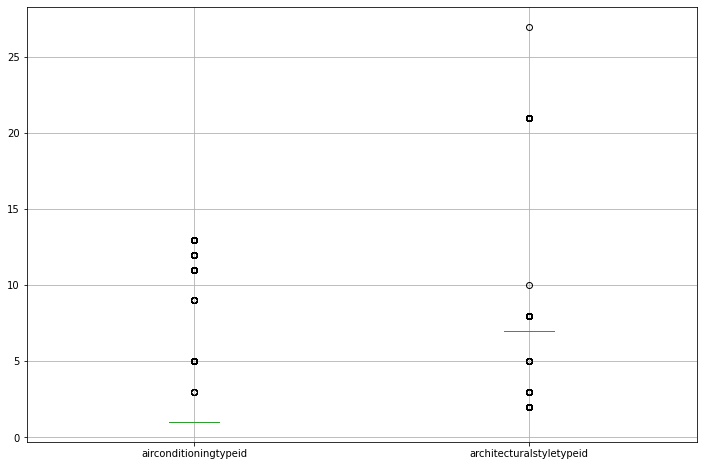

In [8]:
plt.figure(figsize = (12,8))
df_prop[['airconditioningtypeid', 'architecturalstyletypeid']].boxplot()

In [9]:
#Analisi dei duplicati
print(df_prop.duplicated(subset='parcelid').sum())
print(df_prop.duplicated().sum())

0
0


In [10]:
#pd.merge(df_train, df_prop, on='parcelid').equals(pd.merge(df_train, df_prop, on='parcelid', how='left'))

In [11]:
df_prop=df_train.merge(df_prop, on='parcelid')
df_prop['transactiondate']=pd.to_datetime(df_prop['transactiondate'], format='%Y-%m-%d')
df_prop[df_prop.select_dtypes(np.float64).columns] = df_prop.select_dtypes(np.float64).astype(np.float32)

Dataset dopo il merge:

In [12]:
df_prop.info()
print('Shape: ', df_prop.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 90274
Data columns (total 60 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   parcelid                      90275 non-null  int64         
 1   logerror                      90275 non-null  float32       
 2   transactiondate               90275 non-null  datetime64[ns]
 3   airconditioningtypeid         28781 non-null  float32       
 4   architecturalstyletypeid      261 non-null    float32       
 5   basementsqft                  43 non-null     float32       
 6   bathroomcnt                   90275 non-null  float32       
 7   bedroomcnt                    90275 non-null  float32       
 8   buildingclasstypeid           16 non-null     float32       
 9   buildingqualitytypeid         57364 non-null  float32       
 10  calculatedbathnbr             89093 non-null  float32       
 11  decktypeid                  

<a id='features_engineer'></a>
## Features Engineer
<a id='features_num_cat'></a>
### Analisi delle features numeriche e categoriali


In [13]:
#Selezione delle colonne contenti variabili categoriali sulla base della ducumentazione fornita su Kaggle.com (usate successivamente)
other_cols = ['parcelid', 'airconditioningtypeid','architecturalstyletypeid','buildingqualitytypeid','buildingclasstypeid','decktypeid','fips', 'fireplaceflag', 'hashottuborspa', 'heatingorsystemtypeid', 'pooltypeid10','pooltypeid2','pooltypeid7','propertycountylandusecode','propertylandusetypeid','propertyzoningdesc','rawcensustractandblock', 'censustractandblock', 'regionidcounty', 'regionidcity', 'regionidzip', 'regionidneighborhood','regionidzip','storytypeid','typeconstructiontypeid', 'assessmentyear', 'taxdelinquencyflag', 'taxdelinquencyyear', 'yearbuilt']
numerical_cols = [x for x in df_prop.columns if x not in other_cols]

In [14]:
#Selezione delle colonne non float o int
not_float_col=df_prop.select_dtypes(exclude=[np.float32, np.int64, np.datetime64]).columns
for c in not_float_col:
    print("Column: "+c)
    print("values: ", df_prop[c].unique(), "\n")

Column: hashottuborspa
values:  [nan True] 

Column: propertycountylandusecode
values:  ['0100' '1' '010C' '122' '1129' '34' '1128' '010E' '0104' '0101' '0200'
 '0700' '1111' '01DC' '010D' '1110' '0400' '012C' '010V' '1116' '01HC'
 '010G' '0300' '010F' '1117' '0103' '38' '1210' '0111' '010M' '96' '135'
 '0108' '1014' '1112' '0201' '0109' '1310' '010H' '1410' '1222' '1321'
 '1720' '1011' '1432' '0401' '0102' '012D' '73' '105' '0110' '100V' '0130'
 '8800' '0303' '0210' '1012' '1333' '0114' '01DD' '020G' '040A' '012E'
 '020M' '040V' '070D' '1200' '030G' '1722' '6050' '1421' '010' nan '200'
 '0' '1420' '0131' '0301'] 

Column: propertyzoningdesc
values:  ['LARS' nan 'PSR6' ... 'SHCG' 'COR2YY' 'LNR2RPD-R3'] 

Column: fireplaceflag
values:  [nan True] 

Column: taxdelinquencyflag
values:  [nan 'Y'] 



In [15]:
#Missing values ratio
df_prop.isna().sum().sort_values(ascending=False)/df_prop.shape[0]*100

buildingclasstypeid             99.982276
finishedsquarefeet13            99.963445
storytypeid                     99.952368
basementsqft                    99.952368
yardbuildingsqft26              99.894766
fireplaceflag                   99.754085
architecturalstyletypeid        99.710883
typeconstructiontypeid          99.668790
finishedsquarefeet6             99.533647
decktypeid                      99.271116
poolsizesum                     98.926613
pooltypeid10                    98.713930
pooltypeid2                     98.666297
taxdelinquencyyear              98.024924
taxdelinquencyflag              98.024924
hashottuborspa                  97.380227
yardbuildingsqft17              97.068956
finishedsquarefeet15            96.052063
finishedfloor1squarefeet        92.405428
finishedsquarefeet50            92.405428
fireplacecnt                    89.358073
threequarterbathnbr             86.697314
pooltypeid7                     81.504292
poolcnt                         80

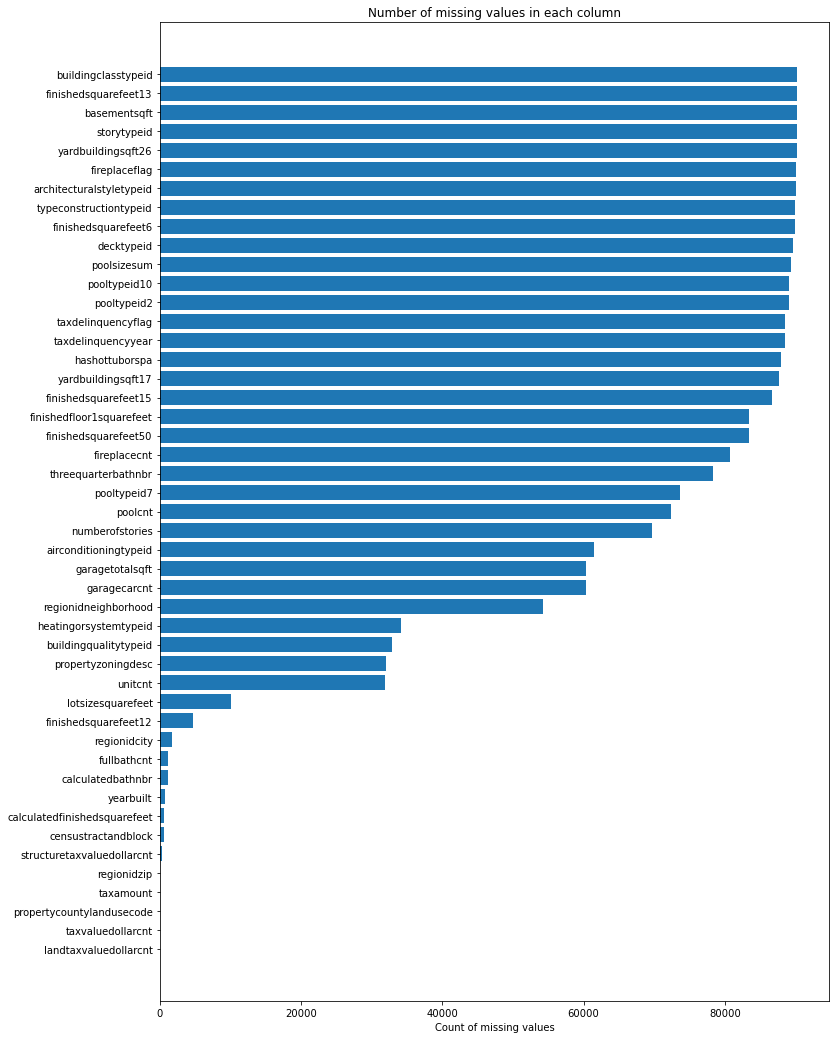

In [16]:
#Missing values graph
df_missing = df_prop.isnull().sum(axis=0).reset_index()
df_missing.columns = ['column_name', 'missing_count']
df_missing = df_missing.loc[df_missing['missing_count']>0]
df_missing = df_missing.sort_values(by='missing_count')

ind = np.arange(df_missing.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, df_missing.missing_count.values)
ax.set_yticks(ind)
ax.set_yticklabels(df_missing.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

Il dataset presenta molte features e istanze. Nello specifico i tipi delle features sono float32(52), int64(1), object(5): 
- alcune di quelle float32 sono in realtà id associati a categorie descritti più approfonditamente nella documentazione di Kaggle.com
- quelle di tipo object sono invece stringhe rappresentanti o valori booleani oppure codici categoriali
Le colonne verranno poi opportunamente gestite in modo da rappresentare la corretta semantica del dato

Il dataset non presenta duplicati ne in parcelid ne globalmente, ma continene moltissimi valori mancanti: diverse colonne infatti presentano una quantità di dati mancanti superiore al 97% sull'intero dataset.

Prossimamente verrà illustrato come vengono gestiti tali valori mancanti per ogni features

<a id='missing_val'></a>
### Gestione dei missing values e rimozione delle colonne non necessarie o che presentano multicollinearità

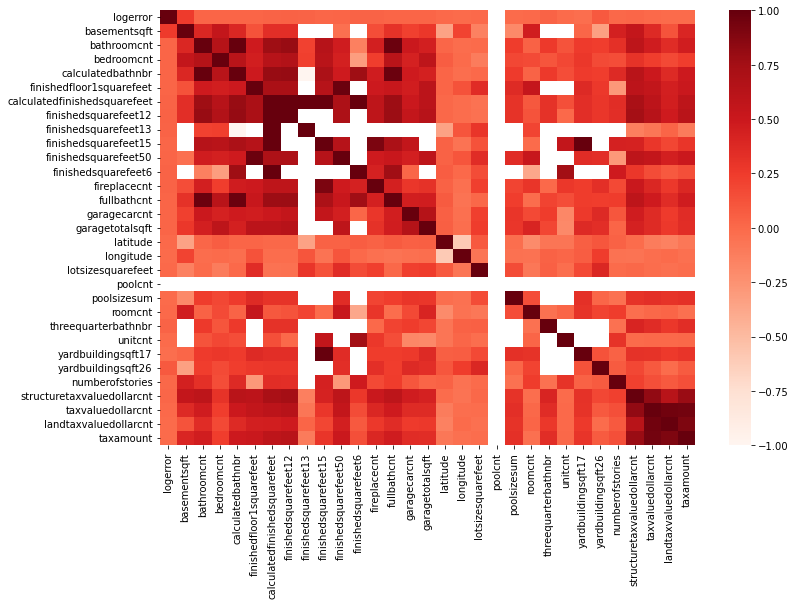

<Figure size 432x288 with 0 Axes>

In [17]:
#Heatmap per visualizzare le correlazioni tra le variabili
plt.figure(figsize = (12,8))
sns.heatmap(data=df_prop[numerical_cols].corr(), cmap='Reds')
plt.show()
plt.gcf().clear()

Dall'analisi della heatmap sulla correlazione tra le variabili numeriche notiamo che le features 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet6', sono molto correlate essendo di colore rosso scuro.
Stesso discorso vale anche per finishedfloor1squarefeet e finishedsquarefeet50, che in più nella documentazione hanno la stessa descrizione.
Discorso simile per 'bathroomcnt', 'calculatedbathnbr' e 'fullbathcnt'

Teniamo quindi solo 'calculatedfinishedsquarefeet' che presenta meno valori missing, mentre tra 'finishedfloor1squarefeet' e 'finishedsquarefeet50' rimuoviamo arbitrariamente 'finishedsquarefeet50'.

Rimuoviamo poi anche 'bathroomcnt' e 'calculatedbathnbr', lasciando 'bathroomcnt' che ha meno missing values

In [18]:
df_prop[['calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet6']].isna().sum()/df_prop.shape[0] *100

calculatedfinishedsquarefeet     0.732207
finishedsquarefeet12             5.183052
finishedsquarefeet13            99.963445
finishedsquarefeet15            96.052063
finishedsquarefeet6             99.533647
dtype: float64

In [19]:
df_prop.drop(columns=['finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet6'], inplace=True)

In [20]:
df_prop[['finishedfloor1squarefeet', 'finishedsquarefeet50']].isna().sum()/df_prop.shape[0] *100

finishedfloor1squarefeet    92.405428
finishedsquarefeet50        92.405428
dtype: float64

In [21]:
df_prop.drop(columns='finishedsquarefeet50', inplace=True)

In [22]:
df_prop[['calculatedbathnbr', 'bathroomcnt', 'fullbathcnt']].isna().sum()/df_prop.shape[0] *100

calculatedbathnbr    1.309333
bathroomcnt          0.000000
fullbathcnt          1.309333
dtype: float64

In [23]:
df_prop.drop(columns=['calculatedbathnbr', 'fullbathcnt'], inplace=True)

'hashottuborspa' e 'pooltypeid10' hanno semanticamente la stessa descrizione. Rimuoviamo 'pooltypeid10' che ha meno valori missing presenti

Inoltre viene assunto che se il valore di pool/hot tub (quindi le features 'pooltypeid2', 'pooltypeid7', 'poolcnt') non è presente questo indichi 0 elementi

In [24]:
print(df_prop['hashottuborspa'].value_counts())
print(df_prop['pooltypeid10'].value_counts())

True    2365
Name: hashottuborspa, dtype: int64
1.0    1161
Name: pooltypeid10, dtype: int64


In [25]:
df_prop[['hashottuborspa', 'pooltypeid10']].isnull().sum()/df_prop.shape[0] *100

hashottuborspa    97.380227
pooltypeid10      98.713930
dtype: float64

In [26]:
df_prop.drop(columns='pooltypeid10', inplace=True)

In [27]:
df_prop[['pooltypeid2', 'pooltypeid7', 'poolcnt']]=df_prop[['pooltypeid2', 'pooltypeid7', 'poolcnt']].fillna(0)
df_prop['hashottuborspa'].fillna(0, inplace=True) #>90% nan
df_prop['hashottuborspa']=df_prop['hashottuborspa'].astype(bool);

Per quanto riguarda la features 'poolsizesum' viene utilizzata la mediana dei valori presenti in 'poolsizesum' alle righe in cui 'poolcnt' è meggiore di 0, altrimenti il valore viene impostato a 0
(si è deciso di usare la mediana come filler perchè meno soggetta ad outliers e perchè si assume che le dimensioni delle piscine negli stati uniti siano più o meno standard) 

In [28]:
median_poolsize=df_prop[df_prop['poolcnt']>0]['poolsizesum'].median()
df_prop.loc[(df_prop['poolcnt']>0) & (df_prop['poolsizesum'].isna()), 'poolsizesum']=median_poolsize

#Se non ha la piscina la dimensione della piscina è 0
df_prop.loc[(df_prop['poolcnt'] == 0), 'poolsizesum'] = 0

'fireplaceflag' e 'fireplacecnt' presentano delle inconsistenze:
come si nota dall'analisi sottostante ci sono righe dove 'fireplacecnt' è presente, mentre 'fireplaceflag' è missing oppure è errato. Si prosegue dunque mettendo a 0 i valori di 'fireplacecnt' non presenti e si modifica in base alla presenza o meno di valori in questo campo la colonna 'fireplaceflag'

In [29]:
df_prop['fireplaceflag'].fillna(0, inplace=True) #>90% nan
df_prop['fireplaceflag']=df_prop['fireplaceflag'].astype(bool)
df_prop.loc[(~df_prop['fireplacecnt'].isna()), 'fireplaceflag']=True
df_prop['fireplacecnt'].fillna(0, inplace=True)

Riempiamo i valori di 'taxdelinquencyflag', 'garagecarcnt', 'garagetotalsqft' applicando le stesse considerazioni fatte finora

In [30]:
df_prop[['taxdelinquencyflag', 'garagecarcnt', 'garagetotalsqft']]=df_prop[['taxdelinquencyflag', 'garagecarcnt', 'garagetotalsqft']].fillna(0)
df_prop['taxdelinquencyflag']=df_prop['taxdelinquencyflag'].astype(bool)

Le features come 'airconditioningtypeid', 'heatingorsystemtypeid',  'threequarterbathnbr' features si ritengono poco importanti e variabili così si è deciso di rimpiazzare i valori missing con la moda di ogni features.<br>
Inoltre i valori di moda ottenuti sembrano ragionevoli visto che si ipotizza che AC e Heating System siano più comunemente 'Central', mentre le abitazioni abbiano solamente un bagno a 3/4

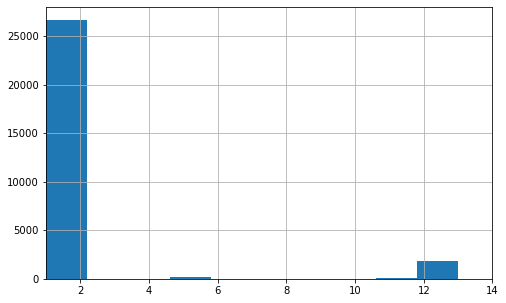

Moda:  1.0


In [31]:
plt.figure(figsize = (8,5))
x_min=df_prop['airconditioningtypeid'].min()
x_max=df_prop['airconditioningtypeid'].max()+1
plt.xlim([x_min, x_max])
df_prop['airconditioningtypeid'].hist()
plt.show()

mode=float(df_prop['airconditioningtypeid'].mode())
print("Moda: ", mode)
df_prop['airconditioningtypeid'].fillna(mode, inplace=True)

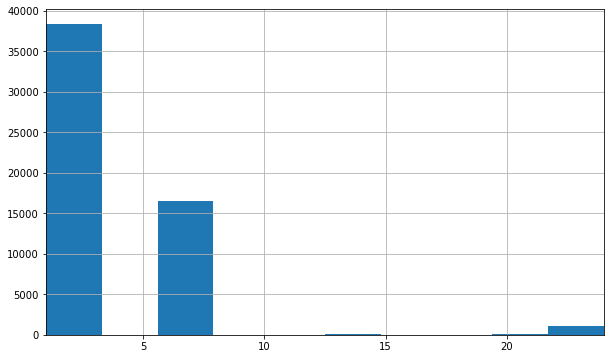

Moda:  2.0


In [32]:
plt.figure(figsize = (10,6))
x_min=df_prop['heatingorsystemtypeid'].min()
x_max=df_prop['heatingorsystemtypeid'].max()
plt.xlim([x_min, x_max])
df_prop['heatingorsystemtypeid'].astype(int, errors='ignore').hist()
plt.show()

mode=float(df_prop['heatingorsystemtypeid'].mode())
print("Moda: ", mode)
df_prop['heatingorsystemtypeid'].fillna(mode, inplace=True)

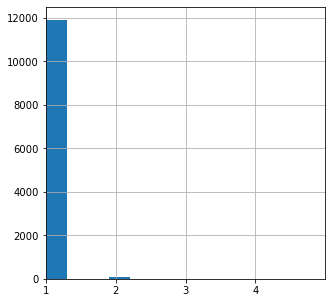

Moda:  1.0


In [33]:
plt.figure(figsize = (5,5))
x_min=df_prop['threequarterbathnbr'].min()
x_max=df_prop['threequarterbathnbr'].max()+1
plt.xlim([x_min, x_max])
plt.xticks(np.arange(x_min, x_max, 1))
df_prop['threequarterbathnbr'].hist()
plt.show()

mode=float(df_prop['threequarterbathnbr'].mode())
print("Moda: ", mode)
df_prop['threequarterbathnbr'].fillna(mode, inplace=True)

Vengono ora rimosse le restanti features con missing value ratio maggiore di 97% perché soggettivamente ritenute con troppo poca informazione per essere utile alla previsione del logerror

In [34]:
tmp_col=df_prop.columns
for c in tmp_col:
    if df_prop[c].isna().sum()/df_prop.shape[0]>0.97:
        df_prop.drop(columns=c, inplace=True)

In [35]:
tmp_col=df_prop.columns
tmp_list=[]

for c in tmp_col:
    if df_prop[c].isna().sum()/df_prop.shape[0]>0.0:
        tmp_list.append(c)

print("Number of missing features: ", len(tmp_list))
print(tmp_list)
print("Number of remining total features: ", len(df_prop.columns))

Number of missing features:  17
['buildingqualitytypeid', 'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'propertycountylandusecode', 'propertyzoningdesc', 'regionidcity', 'regionidneighborhood', 'regionidzip', 'unitcnt', 'yearbuilt', 'numberofstories', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock']
Number of remining total features:  43


Analizziamo ora le features rimanenti cercando di ripristinare gli ultimi missing values

<a id='recover_missing_pos_tax'></a>
### Recupero dei valori missing di features basate sulla posizione e sulle tasse


In [36]:
geo_col_names=['latitude', 'longitude', 'buildingqualitytypeid', 'propertycountylandusecode', 'propertyzoningdesc', 'regionidcity', 'regionidneighborhood', 'regionidzip', 'unitcnt', 'yearbuilt']
df_geo=pd.DataFrame(df_prop[geo_col_names], columns=geo_col_names)
df_geo.isna().sum()/df_geo.shape[0] *100

latitude                      0.000000
longitude                     0.000000
buildingqualitytypeid        36.456383
propertycountylandusecode     0.001108
propertyzoningdesc           35.405151
regionidcity                  1.997231
regionidneighborhood         60.108557
regionidzip                   0.038770
unitcnt                      35.360842
yearbuilt                     0.837441
dtype: float64

Intuitivamente, vista inoltre l'assenza di valori mancanti, si potrebbero utilizzare le features 'latitude' e 'longitude' per ricavare i valori di diversi attributi inerenti alla posizione dell'edificio<br><br>
Ripristino quindi i valori originali di latitudine e longitudine perché come descritto nella documentazine quelli nel dataset sono moltiplicati per 10^6.<br>

In [37]:
df_prop['latitude']=df_prop['latitude']/(10**6)
df_prop['longitude']=df_prop['longitude']/(10**6)
#df_prop.dropna( axis = 0, subset = ['latitude', 'longitude'], inplace = True )

Si è deciso di utilizzare l'algoritmo K-nearest neighbors (KNN) per recuperare queste features basandosi su latitudine e longitudine dell'abitazione come anticipato. Nella cella di codice sottostante sono inoltre spiegate motivazioni e ipotesi usate per il ripristino

In [38]:
warnings.simplefilter(action='ignore', category=UserWarning)
parameters = { 'n_neighbors': [1, 2, 3, 4, 5, 8, 10]}


#Si ipotizza che blocchi di case vicine siano state costruite più o meno tutte nello stesso periodo e che quindi abbiano qualità simili
fun.fillna_knn(df=df_prop, base=['latitude', 'longitude'],
           target='buildingqualitytypeid', tuning_params=parameters)

#Abitazioni vicine hanno lo stesso countrylandusecode  
tmp_label_enc=fun.zoningcode2int(df=df_prop, target='propertycountylandusecode')          
fun.fillna_knn(df=df_prop,
           base=['latitude', 'longitude'],
           target='propertycountylandusecode', tuning_params=parameters)
df_prop['propertycountylandusecode']=tmp_label_enc.inverse_transform(df_prop['propertycountylandusecode'].astype(int))


#Abitazioni vicine hanno la stessa zoning description
tmp_label_enc=fun.zoningcode2int(df=df_prop, target='propertyzoningdesc')
fun.fillna_knn(df=df_prop,
           base=['latitude', 'longitude'],
           target='propertyzoningdesc', tuning_params=parameters)
df_prop['propertyzoningdesc']=tmp_label_enc.inverse_transform(df_prop['propertyzoningdesc'].astype(int))


#Anche in questo caso proprietà vicine con missing value in regionidcity, regionidneighborhood, regionidzip vicine si assume siano simili
fun.fillna_knn(df=df_prop,
           base=['latitude', 'longitude'],
           target='regionidcity', tuning_params=parameters)

fun.fillna_knn(df=df_prop,
           base=['latitude', 'longitude'],
           target='regionidneighborhood', tuning_params=parameters)

fun.fillna_knn(df=df_prop,
           base=['latitude', 'longitude'],
           target='regionidzip', tuning_params=parameters)


#Discorso analogo per i campi 'unitcnt' (Number of units the structure is built into), 'yearbuilt'
fun.fillna_knn(df=df_prop,
           base=['latitude', 'longitude'],
           target='unitcnt', tuning_params=parameters)

fun.fillna_knn(df=df_prop,
           base=['latitude', 'longitude'],
           target='yearbuilt', tuning_params=parameters)

fun.fillna_knn_reg(df=df_prop,
           base=['latitude', 'longitude'],
           target='lotsizesquarefeet', tuning_params=parameters)

warnings.simplefilter(action='default', category=UserWarning)

Target:  buildingqualitytypeid
Best Score: 0.785
Best Params:  {'n_neighbors': 1}
Test Accuracy: 0.803
Done!

Target:  propertycountylandusecode
Dealing with variables that are actually string/categories...
num of categories:  (78,)
Target:  propertycountylandusecode
Best Score: 0.770
Best Params:  {'n_neighbors': 2}
Test Accuracy: 0.781
Done!

Target:  propertyzoningdesc
Dealing with variables that are actually string/categories...
num of categories:  (1997,)
Target:  propertyzoningdesc
Best Score: 0.761
Best Params:  {'n_neighbors': 1}
Test Accuracy: 0.778
Done!

Target:  regionidcity
Best Score: 0.984
Best Params:  {'n_neighbors': 1}
Test Accuracy: 0.987
Done!

Target:  regionidneighborhood
Best Score: 0.969
Best Params:  {'n_neighbors': 1}
Test Accuracy: 0.972
Done!

Target:  regionidzip
Best Score: 0.976
Best Params:  {'n_neighbors': 1}
Test Accuracy: 0.979
Done!

Target:  unitcnt
Best Score: 0.936
Best Params:  {'n_neighbors': 10}
Test Accuracy: 0.936
Done!

Target:  yearbuilt
Be

'hashottuborspa' e 'pooltypeid10' hanno semanticamente la stessa descrizione. Rimuoviamo 'pooltypeid10' che ha meno valori missing presenti

Inoltre viene assunto che se il valore di pool/hot tub (quindi le features 'pooltypeid2', 'pooltypeid7', 'poolcnt') non è presente questo indichi 0 elementi

Per quanto riguarda la feature 'finishedfloor1squarefeet' come si nota dalla heatmap all'inizio questa è correlata con 'calculatedfinishedsquarefeet' quindi proviamo ad utilizzare quest'ultima per fare il fill dei valori

In [ ]:
plt.figure(figsize=(13,13))
sns.jointplot(x=df_prop['finishedfloor1squarefeet'].values, y=df_prop['calculatedfinishedsquarefeet'].values)
plt.ylabel('calculatedfinishedsquarefeet', fontsize=10)
plt.xlabel('finishedfloor1squarefeet', fontsize=10)
plt.title("finishedfloor1squarefeet Vs calculatedfinishedsquarefeet", fontsize=13)
plt.show()

Dal grafico si nota che in alcune abitazioni i valori delle features sono esattamente gli stessi, probabilmente alcune case hanno la loro area complessiva occupata da solamente una stanza (come potrebbe essere una sorta di studio), quindi usiamo queste informazioni ipotetiche per il riempimento.<br>
Inoltre alcune righe del dataset contengono valori di 'finishedfloor1squarefeet' maggiori della dimensione totale dell'abitazione; probabilmente questo è dovuto ad un inserimento del dato in input errato, quindi si è deciso di rimuovere queste righe dal dataset

In [ ]:
df_prop.loc[(df_prop['finishedfloor1squarefeet'].isna()) & (df_prop['numberofstories']==1),'finishedfloor1squarefeet'] = df_prop.loc[(df_prop['finishedfloor1squarefeet'].isna()) & (df_prop['numberofstories']==1),'calculatedfinishedsquarefeet']

droprows = df_prop.loc[df_prop['calculatedfinishedsquarefeet']<df_prop['finishedfloor1squarefeet']].index
df_prop = df_prop.drop(droprows)

In [ ]:
tmp_col=df_prop.columns
tmp_list=[]

for c in tmp_col:
    if df_prop[c].isna().sum()/df_prop.shape[0]>0.0:
        tmp_list.append(c)

print("Number of missing features: ", len(tmp_list))
print(tmp_list)

Occupiamoci ora delle variabili inerenti alle tasse sugli edifici

In [ ]:
tax_col_names=['taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'structuretaxvaluedollarcnt', 'taxamount']
df_tax=pd.DataFrame(df_prop[tax_col_names], columns=tax_col_names)
df_tax.isna().sum()/df_tax.shape[0] *100

Proviamo a recuperare i valori di 'structuretaxvaluedollarcnt', 'taxamount' e 'landtaxvaluedollarcnt'; la variabile più significativa da usare come supporto si ipotizza essere 'taxvaluedollarcnt', che continene anche il minor numero di valori missing.<br>
Svolgiamo quindi il fill dei valori nan di 'taxvaluedollarcnt' usando la sua mediana, in modo che questo valore sia meno sensibile agli outliers.

In [ ]:
median=df_prop['taxvaluedollarcnt'].median()
df_prop['taxvaluedollarcnt'].fillna(median, inplace=True)

Da un analisi sulla correlazione e su grafici delle distribuzioni per le tre variabili target si nota inoltre che 'taxvaluedollarcnt' è la variabile più correlata per tutte: proviamo quindi a svolgere una predizione dei valori missing usando l'algoritmo KNN

In [ ]:
x =  df_tax.corr()

print('Target: structuretaxvaluedollarcnt')
print(x['structuretaxvaluedollarcnt'].sort_values(ascending = False))
plt.figure(figsize=(12,12))
sns.jointplot(x=df_tax['structuretaxvaluedollarcnt'].values, y=df_tax['taxvaluedollarcnt'].values)
plt.ylabel('taxvaluedollarcnt', fontsize=12)
plt.xlabel('structuretaxvaluedollarcnt', fontsize=12)
plt.title("structuretaxvaluedollarcnt Vs taxvaluedollarcnt", fontsize=15)
plt.show()

print('Target: taxamount')
print(x['taxamount'].sort_values(ascending = False))
plt.figure(figsize=(12,12))
sns.jointplot(x=df_tax['taxamount'].values, y=df_tax['taxvaluedollarcnt'].values)
plt.ylabel('taxvaluedollarcnt', fontsize=12)
plt.xlabel('taxamount', fontsize=12)
plt.title("taxamount Vs taxvaluedollarcnt", fontsize=15)
plt.show()

print('Target: landtaxvaluedollarcnt')
print(x['landtaxvaluedollarcnt'].sort_values(ascending = False))
plt.figure(figsize=(12,12))
sns.jointplot(x=df_tax['landtaxvaluedollarcnt'].values, y=df_tax['taxvaluedollarcnt'].values)
plt.ylabel('taxvaluedollarcnt', fontsize=12)
plt.xlabel('landtaxvaluedollarcnt', fontsize=12)
plt.title("landtaxvaluedollarcnt Vs taxvaluedollarcnt", fontsize=15)
plt.show()

In [ ]:
parameters = { 'n_neighbors': [10, 20, 30, 40, 50, 100]}
fun.fillna_knn_reg(df = df_prop, base = ['taxvaluedollarcnt'], target = 'structuretaxvaluedollarcnt', tuning_params=parameters)
fun.fillna_knn_reg(df = df_prop, base = ['taxvaluedollarcnt'], target = 'taxamount', tuning_params=parameters)
fun.fillna_knn_reg(df = df_prop, base = ['taxvaluedollarcnt'], target = 'landtaxvaluedollarcnt', tuning_params=parameters)

In [ ]:
tmp_col=df_prop.columns
tmp_list=[]

for c in tmp_col:
    if df_prop[c].isna().sum()/df_prop.shape[0]>0.0:
        tmp_list.append(c)

print("Number of missing features: ", len(tmp_list))
print(tmp_list)

Rimangono ora solamente poche features con valori missing, si procede riempendo:
- riempiendo 'numberofstories' con la sua moda
- rimuovendo la colonna 'censustractandblock', perché è già presente l'attributo 'rawcensustractandblock' che non contiene valori mancanti, anche se contiene l'informazione grezza
- costruendo un modello predittivo per 'calculatedfinishedsquarefeet' basato su 'bathroomcnt', 'bedroomcnt', 'structuretaxvaluedollarcnt'; si ipotizza infatti che la dimensione totale finale dell'area abitabile sia dipendente da quanti bagni e camere da letto ci sono e da quante tasse sulla struttura dell'abitazione sono presenti
- costruendo un modello predittivo per 'finishedfloor1squarefeet' basato sulle stesse features precedenti e sul numero di piani della casa (numberofstories)

In [ ]:
plt.figure(figsize = (5,5))
x_min=df_prop['numberofstories'].min()
x_max=df_prop['numberofstories'].max()+1
plt.xlim([x_min, x_max])
plt.xticks(np.arange(x_min, x_max, 1))
df_prop['numberofstories'].hist()
plt.show()

mode=float(df_prop['numberofstories'].mode())
print("Moda: ", mode)
df_prop['numberofstories'].fillna(mode, inplace=True)

In [ ]:
df_prop.drop(columns='censustractandblock', inplace=True)

In [ ]:
fun.fillna_knn_reg(df = df_prop, base = ['bathroomcnt', 'bedroomcnt', 'structuretaxvaluedollarcnt'], target = 'calculatedfinishedsquarefeet', tuning_params=parameters)
fun.fillna_knn_reg(df = df_prop, base = ['bathroomcnt', 'bedroomcnt', 'structuretaxvaluedollarcnt', 'numberofstories'], target = 'finishedfloor1squarefeet', tuning_params=parameters)

In [ ]:
tmp_col=df_prop.columns
tmp_list=[]

for c in tmp_col:
    if df_prop[c].isna().sum()/df_prop.shape[0]>0.0:
        tmp_list.append(c)

print("Number of missing features: ", len(tmp_list))

In [ ]:
print("Columns:")
print(df_prop.columns)
print("Shape: ", df_prop.shape)

In [ ]:
%store df_prop

<a id='custom_features'></a>
### Aggiunta di features custom potenzialmente utili

Aggiungiamo ora alcune features custom che intuitivamente potrebbero essere utili per la costruzione del modello finale

In [ ]:
#***Features relative a proprietà dell'edificio***
#Età dell'edificio al momento della vendita
df_prop['yearbuilt']=pd.to_datetime(df_prop['yearbuilt'], format='%Y')
df_prop['assessmentyear']=pd.to_datetime(df_prop['assessmentyear'], format='%Y')
df_prop['Life-until-selling']=(df_prop['transactiondate']-df_prop['yearbuilt']).dt.days

#Rapporto tra structure value e land area 
df_prop['N-ValueProp'] = df_prop['structuretaxvaluedollarcnt']/df_prop['landtaxvaluedollarcnt']

#Porzione di area vivibile
df_prop['N-LivingAreaProp'] = df_prop['calculatedfinishedsquarefeet']/df_prop['lotsizesquarefeet']

#Quantità di spazio extra
df_prop['N-ExtraSpace'] = df_prop['lotsizesquarefeet'] - df_prop['calculatedfinishedsquarefeet'] 

#Features che indica se la proprietà ha garage, piscina o ibromassaggio and AC
df_prop['N-GarPoolAC'] = ((df_prop['garagecarcnt']>0) & (df_prop['hashottuborspa']>0) & (df_prop['airconditioningtypeid']!=5))*1
df_prop['N-GarPoolAC']=df_prop['N-GarPoolAC'].astype(bool)

In [ ]:
#Rapporto tasse sulla casa su tasse totali per assesment year
df_prop['N-ValueRatio'] = df_prop['taxvaluedollarcnt']/df_prop['taxamount']

#Total Tax Score
df_prop['N-TaxScore'] = df_prop['taxvaluedollarcnt']*df_prop['taxamount']

In [ ]:
#***Features relative alla posizione***
#Numero di proprietà per zip code
zip_count = df_prop['regionidzip'].value_counts().to_dict()
df_prop['N-zip_count'] = df_prop['regionidzip'].map(zip_count)

#Numero di proprietà per città
city_count = df_prop['regionidcity'].value_counts().to_dict()
df_prop['N-city_count'] = df_prop['regionidcity'].map(city_count)

#Numero di proprietà per per paese
region_count = df_prop['regionidcounty'].value_counts().to_dict()
df_prop['N-county_count'] = df_prop['regionidcounty'].map(region_count)

In [ ]:
#***Features semplificazione di altre***
#Indicatore se AC è presente o no
df_prop['N-ACInd'] = (df_prop['airconditioningtypeid']!=5)*1
df_prop['N-ACInd']=df_prop['N-ACInd'].astype(bool)

#Indicatore se riscaldamento è presente o no
df_prop['N-HeatInd'] = (df_prop['heatingorsystemtypeid']!=13)*1
df_prop['N-HeatInd']=df_prop['N-HeatInd'].astype(bool)

#Tipo di destinazione d'uso del terreno per il quale è suddiviso in zone l'immobile - prima erano 25 categorie, ora vengono compresse a 4
df_prop['N-PropType'] = df_prop['propertylandusetypeid'].replace({31 : "Mixed", 46 : "Other", 47 : "Mixed", 246 : "Mixed", 247 : "Mixed", 248 : "Mixed", 260 : "Home", 261 : "Home", 262 : "Home", 263 : "Home", 264 : "Home", 265 : "Home", 266 : "Home", 267 : "Home", 268 : "Home", 269 : "Not Built", 270 : "Home", 271 : "Home", 273 : "Home", 274 : "Other", 275 : "Home", 276 : "Home", 279 : "Home", 290 : "Not Built", 291 : "Not Built" })
df_prop.drop(columns='propertylandusetypeid', inplace=True)

In [ ]:
#Altre features relative a structuretaxvaluedollarcnt perché viene considerata una colonna importante
#Media di structuretaxvaluedollarcnt per città
group = df_prop.groupby('regionidcity')['structuretaxvaluedollarcnt'].aggregate('mean').to_dict()
df_prop['N-Avg-structuretaxvaluedollarcnt'] = df_prop['regionidcity'].map(group)

#Discostamento del valore dalla media
df_prop['N-Dev-structuretaxvaluedollarcnt'] = abs((df_prop['structuretaxvaluedollarcnt'] - df_prop['N-Avg-structuretaxvaluedollarcnt']))/df_prop['N-Avg-structuretaxvaluedollarcnt']

In [ ]:
#Nel caso ci siano valori "Infinito" derivanti da divisioni per 0 vengono posti a 0 perché semanticamente errati
df_prop.replace([np.inf, -np.inf], 0, inplace=True)

In [ ]:
#Converione dei tipi delle nuove features da float64 a float32 per ridurre lo spazio occupato in memoria
df_prop[df_prop.select_dtypes(np.float64).columns] = df_prop.select_dtypes(np.float64).astype(np.float32)

In [ ]:
df_prop.info()
print("Shape: ", df_prop.shape)

In [ ]:
%store df_prop

<a id='features_selection'></a>
### Features importance, features selection e preparazione del dataset finale


Arrivati a questo punto il dataset non presenta più valori mancanti e sono stati risolti i problemi di multicollinearità tra le variabili evidenziati nelle analisi precedenti. Si può quindi procedere alla selezione delle features di maggior impatto per la costruzione di modelli previsionali intuitivamente ancora più accurati

In [ ]:
cat_var_names=set(['airconditioningtypeid', 'heatingorsystemtypeid', 'propertycountylandusecode', 'N-PropType',
       'propertyzoningdesc', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 'fips', 'rawcensustractandblock'])

for c in cat_var_names:
    print(c, len(df_prop[c].unique()) )

Come passo per questa preparazione si decide di rimuovere le variabili categoriali con molti elementi distinti (in particolare 'propertyzoningdesc', 'propertycountylandusecode', 'regionidneighborhood', 'regionidzip', 'regionidcity', 'rawcensustractandblock') in modo da non aumentare in modo esponenziale la dimensione della matrice durante il processo di OneHotEncoding ed innalzare il tempo richiesto per il training e il testing dei modelli.<br>
Il processo di encoding è necessario per la corretta gestione di features categriali, altrimenti queste verrebbero interpretate in modo ordinale 

In [ ]:
removed_cat=set(['propertyzoningdesc', 'propertycountylandusecode' , 'regionidneighborhood', 'regionidzip', 'regionidcity', 'rawcensustractandblock'])
one_hot_colmuns=list(cat_var_names.difference(removed_cat))

#enc_propertycountylandusecode=fun.zoningcode2int(df_prop,'propertycountylandusecode')
#enc_propertyzoningdesc=fun.zoningcode2int(df_prop,'propertyzoningdesc')

one_hot_enc=OneHotEncoder(sparse=False)
one_hot_enc.fit(df_prop[one_hot_colmuns])
one_hot_tranform_name=one_hot_enc.get_feature_names(one_hot_colmuns)

one_hot_df=pd.DataFrame(one_hot_enc.transform(df_prop[one_hot_colmuns]), columns=one_hot_tranform_name)

df_prop_drop_cat=df_prop.drop(columns=list(cat_var_names))
df_prop_final=pd.concat([df_prop_drop_cat.reset_index(), one_hot_df.reset_index()], axis=1)
df_prop_final.drop(columns=['index'], inplace=True)


#Convert date to integer
df_prop_final['yearbuilt']=df_prop_final['yearbuilt'].dt.year
df_prop_final['assessmentyear']=df_prop_final['assessmentyear'].dt.year

In [ ]:
print("Final shape: ", df_prop_final.shape)

In [ ]:
X=df_prop_final.drop(columns=['parcelid', 'logerror', 'transactiondate'])
y=df_prop_final['logerror'].values

X e y conterranno rispettivamente:
- le features da usare per la costruzione del modello
- le etichette reali da utilizzare per il task di supervised learning

(Si fa notare che le variabili contengono solo dati di tipo float (o convertibili in float) perché tipi richiesti dagli algoritmi utilizzati)

Procediamo quindi al tuning dei parametri per la costruzione di modello ML di tipo gradient boosting.
Una volta allenato con la migliore combinazione di parametri questo verrà usato per selezionae delle features di maggior impatto.<br>
Si fa notare che è stato scelto questo modello per la sua elevata potenza e efficienza

In [ ]:
tuning_params={'n_estimators': [10, 20, 30, 50, 100, 200]}
X_train_80, X_test, y_train_80, y_test = train_test_split(X, y, 
                                                         test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid  = train_test_split(X_train_80, y_train_80, 
                                                       test_size=0.25, random_state=42)
'''
errors=[]
for c in tuning_params['n_estimators']:
    rf=RandomForestRegressor(n_estimators=c, n_jobs=-1)

    scores = cross_val_score(rf, X_train_80, y_train_80, 
                         cv=5, scoring='neg_mean_squared_error', 
                         verbose = 0, n_jobs=-1)
    
    valid_mse = -scores.mean()
    print ("n_estimators: {:8.4f} - Validation MSE: {:.4f}"
           .format( c, valid_mse) )
    
    errors += [ [valid_mse, c] ]

best_mse, best_c = min(errors)
print ( "Best n_estimators:", best_c )''';

In [ ]:
print("Traning Random Forest with the best n_estimators parameter...")
rf = RandomForestRegressor(n_estimators=200, n_jobs=-1) #TODO modificare
rf.fit(X_train_80, y_train_80)

test_mse = mean_squared_error(y_true = y_test, 
                          y_pred = rf.predict(X_test) )

print ("Test MSE: {:.4f}".format(test_mse))

In [ ]:
fun.plot_feature_importance(rf.feature_importances_, X.columns, 'Random Forest', limit=40)

Si nota dal grafico che molte delle features custom aggiunte precedentemente hanno un peso rilevante nella costruzione del modello

Vengono ora scelto mediante il successivo metodo di feature ranking con recursive feature elimination usante cross-validation sets il presunto miglior sottinsieme di n features in modo da ridurre la dimensionalità del dataframe (problemi di multicollinearità e curse of dimentionality) e ottimizzare maggiormente le previsioni

In [ ]:
%store rf

In [ ]:
selector = RFECV(rf, 
                 step=1,
                 cv=5,
                 scoring='neg_mean_squared_error',
                 min_features_to_select=1,
                 n_jobs=-1
                )

In [ ]:
selector.fit(X,y)
selector.n_features_

Le features selezionate dall'algoritmo sono quindi 11, nello specifico:

In [ ]:
list_important_features=[x[0] for x in list(zip(X.columns, selector.support_)) if x[1]]
print(list_important_features)

['calculatedfinishedsquarefeet', 'latitude', 'longitude', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'N-ValueRatio', 'N-Avg-structuretaxvaluedollarcnt', 'N-Dev-structuretaxvaluedollarcnt', 'regionidcity_33612.0']

Creiamo e salviamo quindi il dataset contenete le features selezionate in modo che possa poi essere usato per la costruzione dei due modelli finali

In [ ]:
selected_important_X=X[list_important_features]

In [ ]:
selected_important_X.shape

In [ ]:
%store selected_important_X
%store y

In [ ]:
selected_important_X.to_parquet(input_folder+"final_df_2016.parquet")

In [ ]:
a

<a id='mod_1'></a>
### Corstruzione del modello sfruttante Random Forest e tuning dei suoi parametri

In [ ]:
#Parametri: Learning rate, numero di foglie, numero di stimatori (i più importanti)

In [ ]:
tuning_params={'n_estimators': [1, 2, 3, 5, 10, 30, 50]}
X_train_80, X_test, y_train_80, y_test = train_test_split(selected_important_X, y, 
                                                         test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid  = train_test_split(X_train_80, y_train_80, 
                                                       test_size=0.25, random_state=42)

errors=[]
for c in tuning_params['n_estimators']:
    rf=RandomForestRegressor(n_estimators=c, n_jobs=-1)

    scores = cross_val_score(rf, X_train_80, y_train_80, 
                         cv=5, scoring='neg_mean_squared_error', 
                         verbose = 0, n_jobs=-1)
    
    valid_mse = -scores.mean()
    print ("n_estimators: {:8.3f} - Validation MSE: {:.3f}"
           .format( c, valid_mse) )
    
    errors += [ [valid_mse, c] ]

best_mse, best_c = min(errors)
print ( "Best n_estimators:", best_c )

In [ ]:
print("Traning Random Forest with the best n_estimators parameter...")
rf_model = RandomForestRegressor(n_estimators=best_c, n_jobs=-1)
rf_model.fit(X_train_80, y_train_80)

test_mse = mean_squared_error(y_true = y_test, 
                          y_pred = rf_model.predict(X_test) )

print ("Test MSE: {:.3f}".format(test_mse))

<a id='mod_2'></a>
### Corstruzione del modello sfruttante Gradient Boosting e tuning dei suoi parametri

https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook
https://www.kaggle.com/code/prashant111/xgboost-k-fold-cv-feature-importance/notebook

In [ ]:
tuning_params={'n_estimators': [1, 2, 3, 5, 10, 30, 50]}
X_train_80, X_test, y_train_80, y_test = train_test_split(selected_important_X, y, 
                                                         test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid  = train_test_split(X_train_80, y_train_80, 
                                                       test_size=0.25, random_state=42)

errors=[]
for c in tuning_params['n_estimators']:
    xgb_model=xgb.XGBRegressor(n_estimators=c, n_jobs=-1)

    scores = cross_val_score(xgb_model, X_train_80, y_train_80, 
                         cv=5, scoring='neg_mean_squared_error', 
                         verbose = 0, n_jobs=-1)
    
    valid_mse = -scores.mean()
    print ("n_estimators: {:8.3f} - Validation MSE: {:.3f}"
           .format( c, valid_mse) )
    
    errors += [ [valid_mse, c] ]

best_mse, best_c = min(errors)
print ( "Best n_estimators:", best_c )

In [ ]:
print("Traning XGBoost with the best n_estimators parameter...")
xgb_model = xgb.XGBRegressor(n_estimators=best_c, n_jobs=-1)
xgb_model.fit(X_train_80, y_train_80)

test_mse = mean_squared_error(y_true = y_test, 
                          y_pred = xgb_model.predict(X_test) )

print ("Test MSE: {:.3f}".format(test_mse))

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(range(len(y_test)), rf_model.predict(X_test), label = "RF")
plt.plot(range(len(y_test)), xgb_model.predict(X_test), label = "XGB")
plt.plot(range(len(y_test)), y_test, label = "Real val")


In [ ]:
xgb1 = xgb.XGBRegressor() 
#TODO: CAMBIARE TUTTO
parameters = {'learning_rate': [.03], #so called `eta` value
              'max_depth': [5],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [2]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 5,
                        n_jobs = -1,
                        verbose=0)
xgb_grid.fit(X_train_80,
         y_train_80)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

In [ ]:
dtrain = xgb.DMatrix(X_train_80, label=y_train_80) #DMatrix è un tipo nativo usato da xgboost simile a numpy o pandas
dtest = xgb.DMatrix(X_test, label=y_test)
xgb_model=xgb.train(params={}, dtrain=dtrain, num_boost_round=5)
'''
# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))
'''


<a id='comparison_and_analisys'></a>
### Comparazione e analisi dei modelli

FARE GRAFICO dei val di xgb e di rf rispetto a logerror e una metrica di errore "finale"
(asse x: lunghezza del vettore contenente le y, asse y: valori di y per entrambi i cosi, metto la legenda, titolo ecc)

In [ ]:
'''from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

#calcolo le cose di prima su un dataset realistico:
N_TESTS = 5

stats = np.array([])

boosts = range(1,51)
for l in boosts:
    y_preds = np.array([])
    
    for i in range(N_TESTS):
        Xs, ys = resample(X,y, n_samples=int(0.67*len(y)) )

        # train a decision tree classifier
        rf = RandomForestRegressor(n_estimators=l)
        rf.fit(Xs,ys)
        
        y_pred = rf.predict(X)
        y_preds = np.column_stack( [y_preds, y_pred] ) if y_preds.size else y_pred

    dt_bias     = (y-np.mean(y_preds,axis=1))**2
    dt_variance = np.var(y_preds,axis=1)
    dt_error    = (y_preds - y.reshape(-1,1))**2.0
        
    run_stats = np.array([dt_error.mean(), dt_bias.mean(), dt_variance.mean()])
    
    stats = np.column_stack( [stats, run_stats]) if stats.size else run_stats
    
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(boosts,stats[0,:], 'o:', label='Error')
ax.plot(boosts,stats[1,:], 'o:', label='Bias$^2$')
ax.plot(boosts,stats[2,:], 'o:', label='Variance')
ax.set_xlabel('Number of Trees')
ax.grid()
ax.legend()

print ("Error/Bias/Variance at the last iteration:", stats[:,-1])

#Un dataset reale è difficile abbia bias 0, ma comunque vedo che ho ridotto la varianza''';

<a id='final'></a>
### Considerazioni finali

In [ ]:
'''
tuning_params={'n_estimators': [1, 2, 3, 5, 10, 30, 50, 100]}
errors=[]
for c in tuning_params['n_estimators']:
    xgb_model=xgb.XGBRegressor(n_estimators=c)
    # model.fit(X_train, y_train)

    scores = cross_val_score(xgb_model, X_train_80, y_train_80, 
                         cv=5, scoring='neg_mean_squared_error', 
                         verbose = 0, n_jobs=-1) #uso l'alg descritto appena sopra
                         #cv: numero di fold (esecuzione con spezzettamenti vari, vedo immagine appena sopra)
    
    #print (scores), score è un vettore
    valid_mse = -scores.mean()
    print ("n_estimators: {:8.3f} - Validation MSE: {:.3f}"
           .format( c, valid_mse) )
    
    errors += [ [valid_mse, c] ]

best_mse, best_c = min(errors)
print ( "Best n_estimators:", best_c )''';